##**1.1. Installing necesarry packages**

In [1]:
!pip install -q torch_snippets
!pip install -q torchinfo
!pip install -q torchmetrics

from torchmetrics import ConfusionMatrix
from torch_snippets import*
from torchinfo import summary
import torch
from torchvision import datasets, transforms
from torch import nn
import matplotlib.pyplot as plt
import sklearn
from sklearn.metrics import classification_report
import pandas as pd

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.4/65.4 kB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 kB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 7.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 203.7/203.7 kB 9.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.3/4.3 MB 18.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 31.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.9/98.9 kB 14.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.7/3.7 MB 34.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.6/30.6 MB 38.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 169.4/169.4 kB 18.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 46.5 MB/s eta 0:

In [2]:
device="cuda" if torch.cuda.is_available() else "cpu"
device #device agniostic code

'cuda'

##**1.2. Getting the data**

In [3]:
transformer= transforms.Compose([transforms.ToTensor()]) #dataset contains imgs in PIL format

In [4]:
train_ds=datasets.MNIST(root="MNIST/", train=True, download=True, transform= transformer)
#convert labels to one hot encoding
test_ds=datasets.MNIST(root="MNIST/", train=False, download=True, transform= transformer)

train_dl= torch.utils.data.DataLoader(train_ds, batch_size=32, drop_last=True)
test_dl= torch.utils.data.DataLoader(test_ds, batch_size=32, drop_last=True)

100%|██████████| 9912422/9912422 [00:00<00:00, 142083807.49it/s]

Extracting MNIST/MNIST/raw/train-images-idx3-ubyte.gz to MNIST/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 115808502.70it/s]

Extracting MNIST/MNIST/raw/train-labels-idx1-ubyte.gz to MNIST/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 39557806.99it/s]

Extracting MNIST/MNIST/raw/t10k-images-idx3-ubyte.gz to MNIST/MNIST/raw




100%|██████████| 4542/4542 [00:00<00:00, 20843029.29it/s]


Extracting MNIST/MNIST/raw/t10k-labels-idx1-ubyte.gz to MNIST/MNIST/raw



In [5]:
im, label=next(iter(train_dl))
im.shape, label.shape #labels are not one hot encoded; img_shape-> [28*28]

(torch.Size([32, 1, 28, 28]), torch.Size([32]))

##**1.3. Building naive_rnn**

In [6]:
input_size=28
sequence_length= 28
hidden_size= 128
num_layers=2
num_classes= 10

In [7]:
class naive_RNN(nn.Module):
  def __init__(self, input_size, hidden_size, num_layers, num_classes):
    super().__init__()
    self.input_size= input_size
    self.hidden_size= hidden_size
    self.num_layers= num_layers
    self.num_classes= num_classes

    self.rnn_block= nn.RNN(input_size, hidden_size, num_layers, batch_first=True)

    self.classification_block= nn.Sequential(nn.Linear(hidden_size, num_classes),
                                             nn.Softmax(dim=-1))

  def forward(self, x):
    h0, c0= torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device), torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
    x, h_out= self.rnn_block(x, h0)
    x= self.classification_block(x[:, -1,:])
    return x

  def loss_and_accuracy(self, y_true, y_p):
    loss_fn= nn.CrossEntropyLoss()
    loss= loss_fn(y_p, y_true)
    y_p= torch.argmax(y_p, dim=-1)
    acc= torch.sum(torch.eq(y_true, y_p))/len(y_true)
    return loss, acc

In [8]:
naive_rnn= naive_RNN(input_size, hidden_size, num_layers, num_classes).to(device)
summary(naive_rnn, input_size= (32, 28, 28), col_names= ["input_size", "output_size", "num_params"])

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #
naive_RNN                                [32, 28, 28]              [32, 10]                  --
├─RNN: 1-1                               [32, 28, 28]              [32, 28, 128]             53,248
├─Sequential: 1-2                        [32, 128]                 [32, 10]                  --
│    └─Linear: 2-1                       [32, 128]                 [32, 10]                  1,290
│    └─Softmax: 2-2                      [32, 10]                  [32, 10]                  --
Total params: 54,538
Trainable params: 54,538
Non-trainable params: 0
Total mult-adds (M): 47.75
Input size (MB): 0.10
Forward/backward pass size (MB): 0.92
Params size (MB): 0.22
Estimated Total Size (MB): 1.24

###**1.3.1. Training the model**

In [9]:
def train_epoch(model, input, criterion, optimizer, sequence_length=28):
  x, y= input
  x, y= x.to(device).view(-1, sequence_length, input_size), y.to(device)
  model.train()
  output=model(x)
  loss, acc=criterion(y, output)
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()
  return loss.item(), acc.item()

def val_epoch(model, input, criterion, sequence_length=28):
  x, y= input
  x, y= x.to(device).view(-1, sequence_length, input_size), y.to(device)
  model.eval()
  with torch.inference_mode():
    output=model(x)
    loss, acc=criterion(y, output)
    return loss.item(), acc.item()

In [10]:
EPOCHS=5 #the val acc seems to saturate after 5th epoch
criterion= naive_rnn.loss_and_accuracy
optimizer=torch.optim.Adam(params= naive_rnn.parameters())

In [11]:
log= Report(EPOCHS)
for epoch in range(EPOCHS):
  n=len(train_dl)
  for ix, input in enumerate(train_dl):
    train_loss, train_accuracy=train_epoch(naive_rnn, input, criterion, optimizer)
    log.record(epoch+(ix+1)/n, train_loss=train_loss, train_acc= train_accuracy, end="\r")
  n=len(test_dl)
  for ix, input in enumerate(test_dl):
    val_loss, val_accuracy=val_epoch(naive_rnn, input, criterion)
    log.record(epoch+(ix+1)/n, val_loss=val_loss, val_acc= val_accuracy, end="\r")
  log.report_avgs(epoch+1)

EPOCH: 1.000  train_loss: 2.012  val_loss: 1.864  train_acc: 0.452  val_acc: 0.598  (20.20s - 80.81s remaining)
EPOCH: 2.000  train_loss: 1.905  val_loss: 1.861  train_acc: 0.558  val_acc: 0.603  (34.29s - 51.43s remaining)
EPOCH: 3.000  train_loss: 2.081  val_loss: 1.953  train_acc: 0.375  val_acc: 0.509  (48.35s - 32.24s remaining)
EPOCH: 4.000  train_loss: 2.015  val_loss: 2.252  train_acc: 0.448  val_acc: 0.205  (62.59s - 15.65s remaining)
EPOCH: 5.000  train_loss: 2.135  val_loss: 2.006  train_acc: 0.326  val_acc: 0.454  (76.71s - 0.00s remaining)


In [12]:
naive_rnn_results= {"train_acc": train_accuracy, "val_acc": val_accuracy, "train_loss": train_loss, "val_loss": val_loss, "epochs": 5}

100%|██████████| 106/106 [00:00<00:00, 428.96it/s]


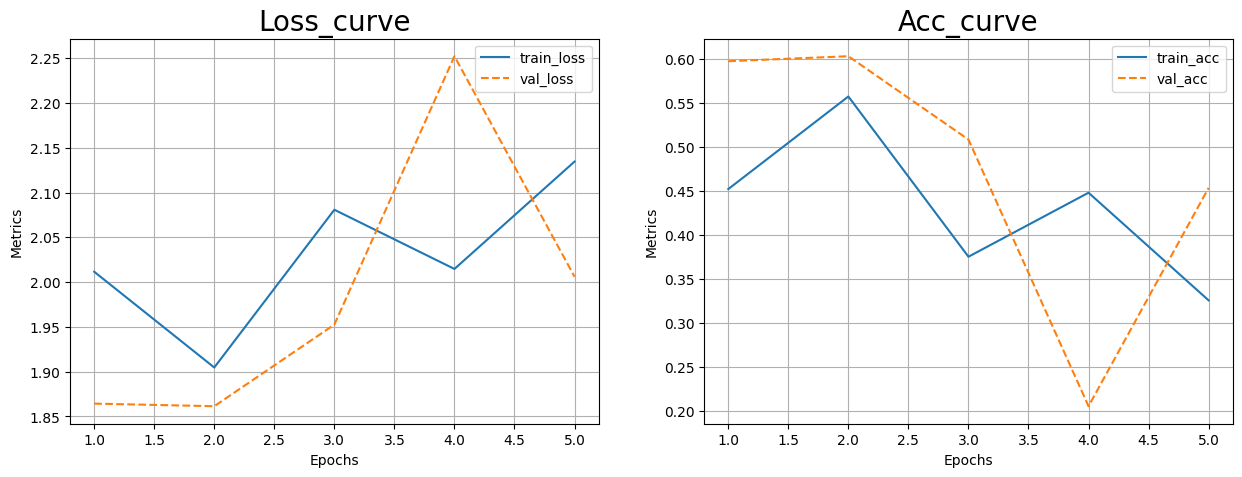

In [13]:
fig, ax= plt.subplots(ncols=2, figsize=(15,5)) #w,h
log.plot_epochs(["train_loss", "val_loss"], ax=ax[0], title="Loss_curve"); #loss_curve
ax[0].legend(loc='upper right', fontsize=10)
log.plot_epochs(["train_acc", "val_acc"], ax=ax[1], title="Acc_curve"); #acc_curve

##**1.4. Building LSTM**

In [14]:
class LSTM(nn.Module):
  def __init__(self, input_size, hidden_size, num_layers, num_classes):
    super().__init__()
    self.input_size= input_size
    self.hidden_size= hidden_size
    self.num_layers= num_layers
    self.num_classes= num_classes

    self.lstm_block= nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)

    self.classification_block= nn.Sequential(nn.Linear(hidden_size, num_classes),
                                             nn.Softmax(dim=-1))

  def forward(self, x):
    h0, c0= torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device), torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
    x, h_out= self.lstm_block(x, (h0, c0))
    x= self.classification_block(x[:, -1,:])
    return x

  def loss_and_accuracy(self, y_true, y_p):
    loss_fn= nn.CrossEntropyLoss()
    loss= loss_fn(y_p, y_true)
    y_p= torch.argmax(y_p, dim=-1)
    acc= torch.sum(torch.eq(y_true, y_p))/len(y_true)
    return loss, acc

In [15]:
lstm= LSTM(input_size, hidden_size, num_layers, num_classes).to(device)
summary(lstm, input_size= (32, 28, 28), col_names= ["input_size", "output_size", "num_params"])

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #
LSTM                                     [32, 28, 28]              [32, 10]                  --
├─LSTM: 1-1                              [32, 28, 28]              [32, 28, 128]             212,992
├─Sequential: 1-2                        [32, 128]                 [32, 10]                  --
│    └─Linear: 2-1                       [32, 128]                 [32, 10]                  1,290
│    └─Softmax: 2-2                      [32, 10]                  [32, 10]                  --
Total params: 214,282
Trainable params: 214,282
Non-trainable params: 0
Total mult-adds (M): 190.88
Input size (MB): 0.10
Forward/backward pass size (MB): 0.92
Params size (MB): 0.86
Estimated Total Size (MB): 1.88

###**1.4.1. Training the model**

In [16]:
EPOCHS=5 #the val acc seems to saturate after 5th epoch
criterion= lstm.loss_and_accuracy
optimizer=torch.optim.Adam(params= lstm.parameters())

In [17]:
log= Report(EPOCHS)
for epoch in range(EPOCHS):
  n=len(train_dl)
  for ix, input in enumerate(train_dl):
    train_loss, train_accuracy=train_epoch(lstm, input, criterion, optimizer)
    log.record(epoch+(ix+1)/n, train_loss=train_loss, train_acc= train_accuracy, end="\r")
  n=len(test_dl)
  for ix, input in enumerate(test_dl):
    val_loss, val_accuracy=val_epoch(lstm, input, criterion)
    log.record(epoch+(ix+1)/n, val_loss=val_loss, val_acc= val_accuracy, end="\r")
  log.report_avgs(epoch+1)

EPOCH: 1.000  train_loss: 1.687  val_loss: 1.562  train_acc: 0.778  val_acc: 0.902  (17.80s - 71.20s remaining)
EPOCH: 2.000  train_loss: 1.522  val_loss: 1.516  train_acc: 0.940  val_acc: 0.945  (33.62s - 50.43s remaining)
EPOCH: 3.000  train_loss: 1.509  val_loss: 1.503  train_acc: 0.952  val_acc: 0.959  (49.39s - 32.93s remaining)
EPOCH: 4.000  train_loss: 1.497  val_loss: 1.506  train_acc: 0.965  val_acc: 0.956  (65.18s - 16.29s remaining)
EPOCH: 5.000  train_loss: 1.495  val_loss: 1.489  train_acc: 0.967  val_acc: 0.972  (81.18s - 0.00s remaining)


In [18]:
lstm_results= {"train_acc": train_accuracy, "val_acc": val_accuracy, "train_loss": train_loss, "val_loss": val_loss, "epochs": 5}

100%|██████████| 106/106 [00:00<00:00, 220.85it/s]


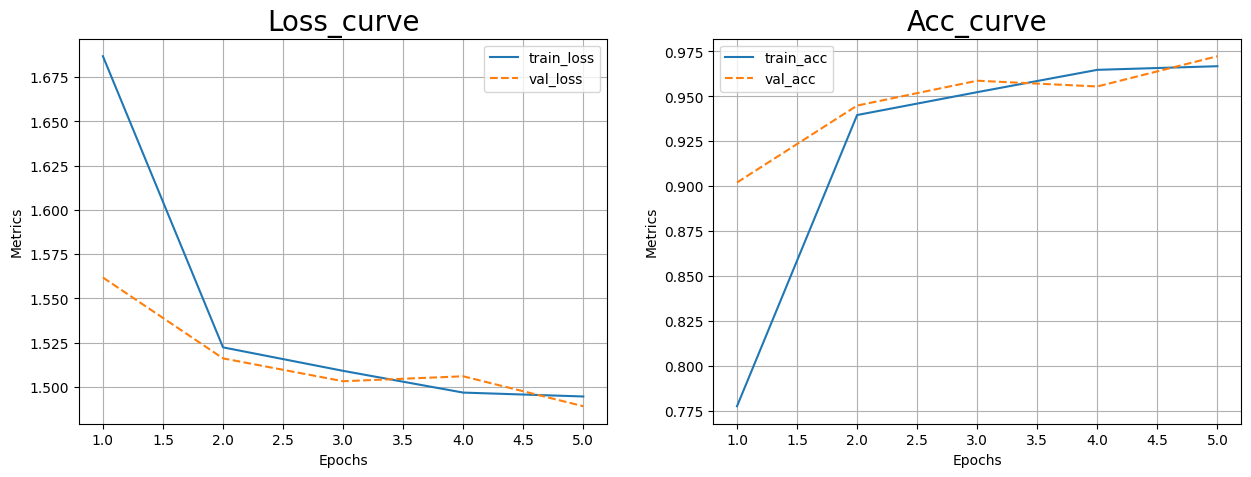

In [19]:
fig, ax= plt.subplots(ncols=2, figsize=(15,5)) #w,h
log.plot_epochs(["train_loss", "val_loss"], ax=ax[0], title="Loss_curve"); #loss_curve
ax[0].legend(loc='upper right', fontsize=10)
log.plot_epochs(["train_acc", "val_acc"], ax=ax[1], title="Acc_curve"); #acc_curve

##**1.5. Building GRU**

In [20]:
class GRU(nn.Module):
  def __init__(self, input_size, hidden_size, num_layers, num_classes):
    super().__init__()
    self.input_size= input_size
    self.hidden_size= hidden_size
    self.num_layers= num_layers
    self.num_classes= num_classes

    self.rnn_block= nn.GRU(input_size, hidden_size, num_layers, batch_first=True)

    self.classification_block= nn.Sequential(nn.Linear(hidden_size, num_classes),
                                             nn.Softmax(dim=-1))

  def forward(self, x):
    h0, c0= torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device), torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
    x, h_out= self.rnn_block(x,h0)
    x= self.classification_block(x[:, -1,:])
    return x

  def loss_and_accuracy(self, y_true, y_p):
    loss_fn= nn.CrossEntropyLoss()
    loss= loss_fn(y_p, y_true)
    y_p= torch.argmax(y_p, dim=-1)
    acc= torch.sum(torch.eq(y_true, y_p))/len(y_true)
    return loss, acc

In [21]:
gru= GRU(input_size, hidden_size, num_layers, num_classes).to(device)
summary(gru, input_size= (32, 28, 28), col_names= ["input_size", "output_size", "num_params"])

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #
GRU                                      [32, 28, 28]              [32, 10]                  --
├─GRU: 1-1                               [32, 28, 28]              [32, 28, 128]             159,744
├─Sequential: 1-2                        [32, 128]                 [32, 10]                  --
│    └─Linear: 2-1                       [32, 128]                 [32, 10]                  1,290
│    └─Softmax: 2-2                      [32, 10]                  [32, 10]                  --
Total params: 161,034
Trainable params: 161,034
Non-trainable params: 0
Total mult-adds (M): 143.17
Input size (MB): 0.10
Forward/backward pass size (MB): 0.92
Params size (MB): 0.64
Estimated Total Size (MB): 1.66

###**1.5.1. Training the model**

In [22]:
EPOCHS=5 #the val acc seems to saturate after 5th epoch
criterion= gru.loss_and_accuracy
optimizer=torch.optim.Adam(params= gru.parameters())

In [23]:
log= Report(EPOCHS)
for epoch in range(EPOCHS):
  n=len(train_dl)
  for ix, input in enumerate(train_dl):
    loss, accuracy=train_epoch(gru, input, criterion, optimizer)
    log.record(epoch+(ix+1)/n, train_loss=loss, train_acc= accuracy, end="\r")
  n=len(test_dl)
  for ix, input in enumerate(test_dl):
    loss, accuracy=val_epoch(gru, input, criterion)
    log.record(epoch+(ix+1)/n, val_loss=loss, val_acc= accuracy, end="\r")
  log.report_avgs(epoch+1)

EPOCH: 1.000  train_loss: 1.637  val_loss: 1.528  train_acc: 0.829  val_acc: 0.934  (14.63s - 58.52s remaining)
EPOCH: 2.000  train_loss: 1.508  val_loss: 1.500  train_acc: 0.955  val_acc: 0.963  (29.07s - 43.60s remaining)
EPOCH: 3.000  train_loss: 1.495  val_loss: 1.491  train_acc: 0.966  val_acc: 0.971  (43.62s - 29.08s remaining)
EPOCH: 4.000  train_loss: 1.489  val_loss: 1.495  train_acc: 0.973  val_acc: 0.967  (58.24s - 14.56s remaining)
EPOCH: 5.000  train_loss: 1.484  val_loss: 1.482  train_acc: 0.977  val_acc: 0.980  (72.74s - 0.00s remaining)


In [24]:
gru_results= {"train_acc": train_accuracy, "val_acc": val_accuracy, "train_loss": train_loss, "val_loss": val_loss, "epochs": 5}

100%|██████████| 106/106 [00:00<00:00, 385.47it/s]


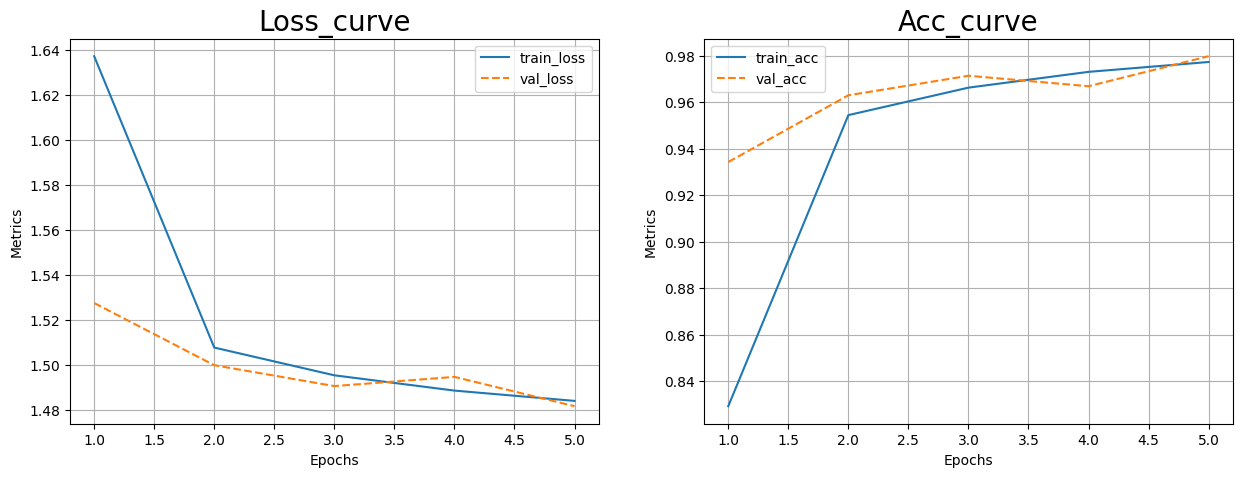

In [25]:
fig, ax= plt.subplots(ncols=2, figsize=(15,5)) #w,h
log.plot_epochs(["train_loss", "val_loss"], ax=ax[0], title="Loss_curve"); #loss_curve
ax[0].legend(loc='upper right', fontsize=10)
log.plot_epochs(["train_acc", "val_acc"], ax=ax[1], title="Acc_curve"); #acc_curve

##**1.6. Building LSTM_bi**

In [26]:
class LSTM_bi(nn.Module):
  def __init__(self, input_size, hidden_size, num_layers, num_classes):
    super().__init__()
    self.input_size= input_size
    self.hidden_size= hidden_size
    self.num_layers= num_layers
    self.num_classes= num_classes

    self.lstm_block= nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, bidirectional= True)

    self.classification_block= nn.Sequential(nn.Linear(2*hidden_size, num_classes),
                                             nn.Softmax(dim=-1))

  def forward(self, x):
    h0, c0= torch.zeros(2*self.num_layers, x.size(0), self.hidden_size).to(device), torch.zeros(2*self.num_layers, x.size(0), self.hidden_size).to(device)
    x, h_out= self.lstm_block(x, (h0, c0))
    x= self.classification_block(x[:, -1,:])
    return x

  def loss_and_accuracy(self, y_true, y_p):
    loss_fn= nn.CrossEntropyLoss()
    loss= loss_fn(y_p, y_true)
    y_p= torch.argmax(y_p, dim=-1)
    acc= torch.sum(torch.eq(y_true, y_p))/len(y_true)
    return loss, acc

In [27]:
lstm_bi= LSTM_bi(input_size, hidden_size, num_layers, num_classes).to(device)
summary(lstm_bi, input_size= (32, 28, 28), col_names= ["input_size", "output_size", "num_params"])

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #
LSTM_bi                                  [32, 28, 28]              [32, 10]                  --
├─LSTM: 1-1                              [32, 28, 28]              [32, 28, 256]             557,056
├─Sequential: 1-2                        [32, 256]                 [32, 10]                  --
│    └─Linear: 2-1                       [32, 256]                 [32, 10]                  2,570
│    └─Softmax: 2-2                      [32, 10]                  [32, 10]                  --
Total params: 559,626
Trainable params: 559,626
Non-trainable params: 0
Total mult-adds (M): 499.20
Input size (MB): 0.10
Forward/backward pass size (MB): 1.84
Params size (MB): 2.24
Estimated Total Size (MB): 4.18

###**1.6.1. Training the model**

In [28]:
EPOCHS=5 #the val acc seems to saturate after 5th epoch
criterion= lstm_bi.loss_and_accuracy
optimizer=torch.optim.Adam(params= lstm_bi.parameters())

In [29]:
log= Report(EPOCHS)
for epoch in range(EPOCHS):
  n=len(train_dl)
  for ix, input in enumerate(train_dl):
    train_loss, train_accuracy=train_epoch(lstm_bi, input, criterion, optimizer)
    log.record(epoch+(ix+1)/n, train_loss=train_loss, train_acc= train_accuracy, end="\r")
  n=len(test_dl)
  for ix, input in enumerate(test_dl):
    val_loss, val_accuracy=val_epoch(lstm_bi, input, criterion)
    log.record(epoch+(ix+1)/n, val_loss=val_loss, val_acc= val_accuracy, end="\r")
  log.report_avgs(epoch+1)

EPOCH: 1.000  train_loss: 1.683  val_loss: 1.535  train_acc: 0.781  val_acc: 0.929  (18.35s - 73.38s remaining)
EPOCH: 2.000  train_loss: 1.518  val_loss: 1.506  train_acc: 0.945  val_acc: 0.956  (35.55s - 53.33s remaining)
EPOCH: 3.000  train_loss: 1.500  val_loss: 1.495  train_acc: 0.962  val_acc: 0.967  (52.79s - 35.20s remaining)
EPOCH: 4.000  train_loss: 1.496  val_loss: 1.495  train_acc: 0.965  val_acc: 0.967  (70.88s - 17.72s remaining)
EPOCH: 5.000  train_loss: 1.492  val_loss: 1.486  train_acc: 0.970  val_acc: 0.975  (87.94s - 0.00s remaining)


In [30]:
lstm_bi_results= {"train_acc": train_accuracy, "val_acc": val_accuracy, "train_loss": train_loss, "val_loss": val_loss, "epochs": 5}

100%|██████████| 106/106 [00:00<00:00, 410.50it/s]


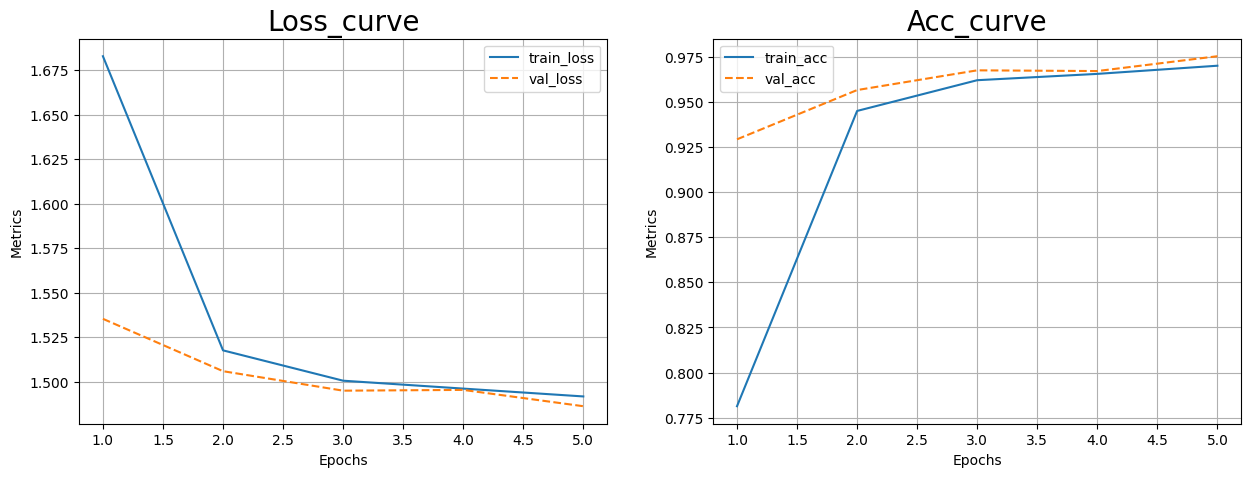

In [31]:
fig, ax= plt.subplots(ncols=2, figsize=(15,5)) #w,h
log.plot_epochs(["train_loss", "val_loss"], ax=ax[0], title="Loss_curve"); #loss_curve
ax[0].legend(loc='upper right', fontsize=10)
log.plot_epochs(["train_acc", "val_acc"], ax=ax[1], title="Acc_curve"); #acc_curve

In [32]:
import pandas as pd
data=[naive_rnn_results, lstm_results, gru_results, lstm_bi_results]
index=["naive_rnn", "lstm", "gru", "lstm_bi"]
result_df= pd.DataFrame(data)
result_df.set_index([index], inplace= True)
result_df

,train_acc,val_acc,train_loss,val_loss,epochs
naive_rnn,0.50000,0.50000,1.970288,1.938931,5
lstm,1.00000,0.93750,1.461198,1.517358,5
gru,1.00000,0.93750,1.461198,1.517358,5
lstm_bi,0.96875,0.96875,1.498682,1.482065,5


Note that the LSTM model and the BiDirectional LSTM perform on par, there is no gain in additional bidirection. So for the best  performing model we shall consider LSTM itself (for lower run time and complexity)

##**1.7. Tesing on val_images**

In [33]:
ims, labels= next(iter(test_dl))
ims, labels= ims[:10], labels[:10]
ims.shape, labels.shape

(torch.Size([10, 1, 28, 28]), torch.Size([10]))

In [36]:
with torch.inference_mode():
  out= lstm(ims.view(-1, 28,28).to(device))
  out= torch.argmax(out, dim=-1)

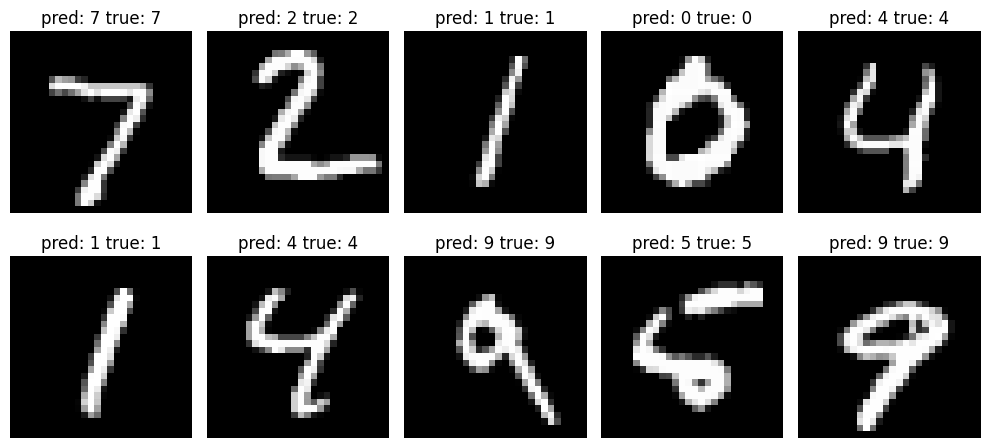

In [37]:
titles=[f"pred: {out[i].item()} true: {labels[i].item()}" for i in range(len(out))]
subplots(ims.squeeze().numpy(), titles=titles, figsize= (10,5))

Our lstm model performs really well.

#**2. Adding 2 binary string**

##**2.1. Custom dataset**

In [38]:
def gen_bin(n):
  gen=[]
  for i in range(2**n, 2**(n+1)):
    gen.append(bin(i))
  return gen

def break_bin(num):
  temp= list(num[3:])
  temp= [int(i) for i in temp]
  return temp

def input_prep(s1, s2):
  label, out= [], []
  num1, num2= break_bin(s1), break_bin(s2)
  num1, num2= num1[::-1], num2[::-1]
  sum = bin(int(s1[3:], 2) + int(s2[3:], 2))[2:]
  for idx in range(len(num1)):
    out.append(torch.Tensor([num1[idx], num2[idx]]))
  sum= list(sum)
  sum=sum[::-1]
  if len(sum)<len(num1)+1:
    sum.extend([0]*(len(num1)+1-len(sum)))
  sum= torch.LongTensor([int(i) for i in sum])
  out= torch.vstack(out)
  return out, sum

In [39]:
import random

class binary_string_dataset(Dataset):
  def __init__(self, samples, binary_string_len):
    self.samples= samples
    self.string_len= binary_string_len
    self.data, self.target=[], []

    for i in range(samples):
      x= gen_bin(binary_string_len)
      idx_1, idx_2= random.randint(0, len(x)-1), random.randint(0, len(x)-1)
      input, target= input_prep(x[idx_1], x[idx_2])
      self.data.extend([input])
      self.target.extend([target])

  def __len__(self):
    return self.samples

  def __getitem__(self, idx):
    return self.data[idx], self.target[idx]

In [40]:
N=10

train_ds= binary_string_dataset(32*10, N)
test_ds= binary_string_dataset(32*3, N)
train_ds[2]

(tensor([[0., 1.],
         [1., 0.],
         [0., 1.],
         [1., 1.],
         [0., 0.],
         [0., 1.],
         [0., 1.],
         [1., 0.],
         [1., 0.],
         [1., 0.]]),
 tensor([1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0]))

In [41]:
len(train_ds)

320

In [42]:
train_dl= torch.utils.data.DataLoader(train_ds, batch_size=32)
test_dl= torch.utils.data.DataLoader(test_ds, batch_size=32)

##**2.2. Setting up a LSTM model**

In [43]:
input_size=2

#hypermarameters:
hidden_size=64
sequence_length= N
num_layers=2
num_classes= N

In [44]:
class LSTM(nn.Module):
  def __init__(self, input_size, hidden_size, num_layers, num_classes):
    super().__init__()
    self.input_size= input_size
    self.hidden_size= hidden_size
    self.num_layers= num_layers
    self.num_classes= num_classes

    self.lstm_block= nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)

    self.classification_block= nn.Sequential(nn.Linear(hidden_size, num_classes+1),
                                             nn.Sigmoid())

  def forward(self, x):
    h0, c0= torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device), torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
    x, h_out= self.lstm_block(x, (h0, c0))
    x= self.classification_block(x[:, -1,:])
    return x

  def loss_and_accuracy(self, y_true, y_p):
    loss_fn= nn.BCELoss()
    y_true= y_true.type(torch.float32)
    loss= loss_fn(y_p, y_true)
    y_p= torch.round(y_p)
    acc= torch.sum(torch.eq(y_true, y_p))/(len(y_true)*(N+1))
    return loss, acc

In [45]:
lstm= LSTM(input_size, hidden_size, num_layers, num_classes).to(device)
summary(lstm, input_size= (32, 5, 2), col_names= ["input_size", "output_size", "num_params"])

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #
LSTM                                     [32, 5, 2]                [32, 11]                  --
├─LSTM: 1-1                              [32, 5, 2]                [32, 5, 64]               50,688
├─Sequential: 1-2                        [32, 64]                  [32, 11]                  --
│    └─Linear: 2-1                       [32, 64]                  [32, 11]                  715
│    └─Sigmoid: 2-2                      [32, 11]                  [32, 11]                  --
Total params: 51,403
Trainable params: 51,403
Non-trainable params: 0
Total mult-adds (M): 8.13
Input size (MB): 0.00
Forward/backward pass size (MB): 0.08
Params size (MB): 0.21
Estimated Total Size (MB): 0.29

In [46]:
EPOCHS=500
criterion= lstm.loss_and_accuracy
optimizer=torch.optim.Adam(params= lstm.parameters())

##**2.3. Running the model**

In [47]:
log= Report(EPOCHS)
for epoch in range(EPOCHS):
  n=len(train_dl)
  for ix, input in enumerate(train_dl):
    train_loss, train_accuracy=train_epoch(lstm, input, criterion, optimizer, sequence_length=sequence_length)
    log.record(epoch+(ix+1)/n, train_loss=train_loss, train_acc= train_accuracy, end="\r")
  n=len(test_dl)
  for ix, input in enumerate(test_dl):
    val_loss, val_accuracy=val_epoch(lstm, input, criterion, sequence_length=sequence_length)
    log.record(epoch+(ix+1)/n, val_loss=val_loss, val_acc= val_accuracy, end="\r")
  log.report_avgs(epoch+1)

EPOCH: 1.000  train_loss: 0.693  val_loss: 0.695  train_acc: 0.505  val_acc: 0.462  (0.05s - 27.06s remaining)
EPOCH: 2.000  train_loss: 0.692  val_loss: 0.694  train_acc: 0.520  val_acc: 0.514  (0.09s - 21.82s remaining)
EPOCH: 3.000  train_loss: 0.691  val_loss: 0.694  train_acc: 0.539  val_acc: 0.506  (0.12s - 19.98s remaining)
EPOCH: 4.000  train_loss: 0.691  val_loss: 0.695  train_acc: 0.530  val_acc: 0.507  (0.15s - 19.01s remaining)
EPOCH: 5.000  train_loss: 0.690  val_loss: 0.695  train_acc: 0.539  val_acc: 0.515  (0.19s - 18.44s remaining)
EPOCH: 6.000  train_loss: 0.690  val_loss: 0.694  train_acc: 0.545  val_acc: 0.514  (0.22s - 18.16s remaining)
EPOCH: 7.000  train_loss: 0.689  val_loss: 0.693  train_acc: 0.548  val_acc: 0.512  (0.25s - 17.94s remaining)
EPOCH: 8.000  train_loss: 0.687  val_loss: 0.693  train_acc: 0.545  val_acc: 0.512  (0.29s - 17.95s remaining)
EPOCH: 9.000  train_loss: 0.685  val_loss: 0.691  train_acc: 0.543  val_acc: 0.513  (0.32s - 17.67s remaining)
E

In [48]:
lstm_results= {"train_acc": train_accuracy, "val_acc": val_accuracy, "train_loss": train_loss, "val_loss": val_loss, "epochs": 5}

##**2.4. Plotting the loss and acc curves**

100%|██████████| 601/601 [00:00<00:00, 1257.36it/s]


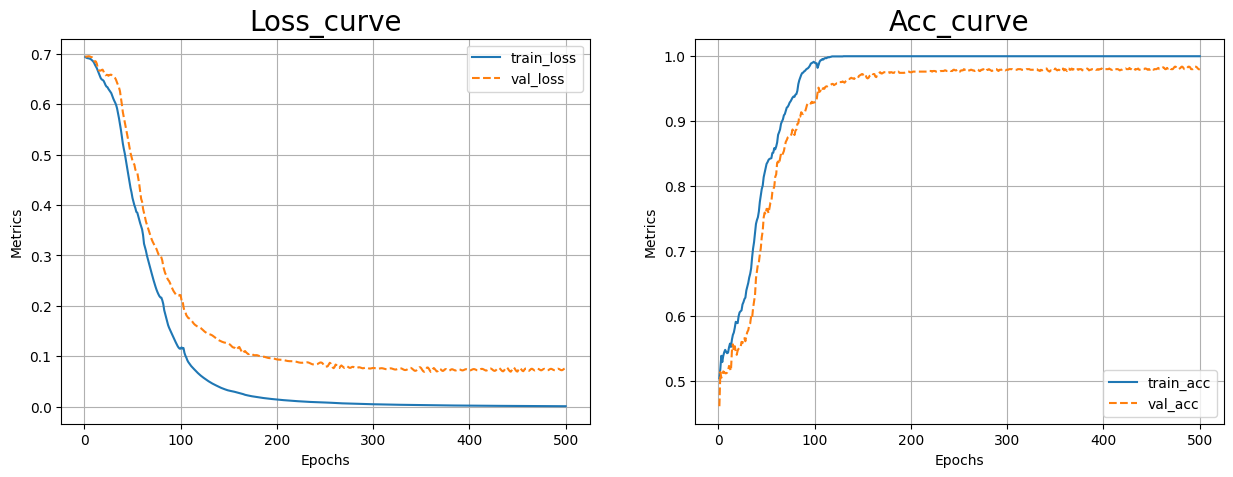

In [49]:
fig, ax= plt.subplots(ncols=2, figsize=(15,5)) #w,h
log.plot_epochs(["train_loss", "val_loss"], ax=ax[0], title="Loss_curve"); #loss_curve
ax[0].legend(loc='upper right', fontsize=10)
log.plot_epochs(["train_acc", "val_acc"], ax=ax[1], title="Acc_curve"); #acc_curve

##**2.5. Testing on a new datapoint**

In [50]:
x=gen_bin(10)
inp, tar= input_prep(x[45], x[64])
x[45], x[64], inp, tar

('0b10000101101',
 '0b10001000000',
 tensor([[1., 0.],
         [0., 0.],
         [1., 0.],
         [1., 0.],
         [0., 0.],
         [1., 0.],
         [0., 1.],
         [0., 0.],
         [0., 0.],
         [0., 0.]]),
 tensor([1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0]))

In [51]:
inp=torch.unsqueeze(inp, dim=0)
inp.shape

torch.Size([1, 10, 2])

In [54]:
torch.round(lstm(inp.to(device)))

tensor([[1., 0., 1., 1., 1., 0., 1., 0., 0., 0., 0.]], device='cuda:0',
       grad_fn=<RoundBackward0>)

**We can see that the rnn network performs very well on the test data.**

##**2.6. Plotting the acc as a function of N**

In [55]:
def experiments(lst_len_of_numbers, epochs):
  train_accs, test_accs=[], []
  input_size=2
  hidden_size=64
  num_layers=2
  for N in lst_len_of_numbers:
    train_ds= binary_string_dataset(32*10, N)
    test_ds= binary_string_dataset(32*3, N)
    train_dl= torch.utils.data.DataLoader(train_ds, batch_size=32)
    test_dl= torch.utils.data.DataLoader(test_ds, batch_size=32)

    sequence_length= N
    num_classes= N

    lstm= LSTM(input_size, hidden_size, num_layers, num_classes).to(device)
    EPOCHS=epochs
    criterion= lstm.loss_and_accuracy
    optimizer=torch.optim.Adam(params= lstm.parameters())
    log= Report(EPOCHS)
    for epoch in range(EPOCHS):
      n=len(train_dl)
      for ix, input in enumerate(train_dl):
        train_loss, train_accuracy=train_epoch(lstm, input, criterion, optimizer, sequence_length=sequence_length)
        log.record(epoch+(ix+1)/n, train_loss=train_loss, train_acc= train_accuracy, end="\r")
      n=len(test_dl)
      for ix, input in enumerate(test_dl):
        val_loss, val_accuracy=val_epoch(lstm, input, criterion, sequence_length=sequence_length)
        log.record(epoch+(ix+1)/n, val_loss=val_loss, val_acc= val_accuracy, end="\r")
    train_accs.append(train_accuracy)
    test_accs.append(val_accuracy)
  return train_accs, test_accs

In [56]:
lst_len_of_numbers=np.arange(1, 11)
epochs=500
train_accs, test_accs= experiments(lst_len_of_numbers, epochs)

EPOCH: 500.000  val_loss: 0.098  val_acc: 0.983  (17.48s - 0.00s remaining)

In [57]:
train_accs, test_accs

([0.1818181872367859,
  0.27272728085517883,
  0.3636363744735718,
  0.4545454680919647,
  0.5454545617103577,
  0.6363636255264282,
  0.7272727489471436,
  0.8181818723678589,
  0.9090909361839294,
  1.0],
 [0.1818181872367859,
  0.27272728085517883,
  0.3636363744735718,
  0.4545454680919647,
  0.5454545617103577,
  0.6363636255264282,
  0.7272727489471436,
  0.8181818723678589,
  0.9090909361839294,
  0.9829545617103577])

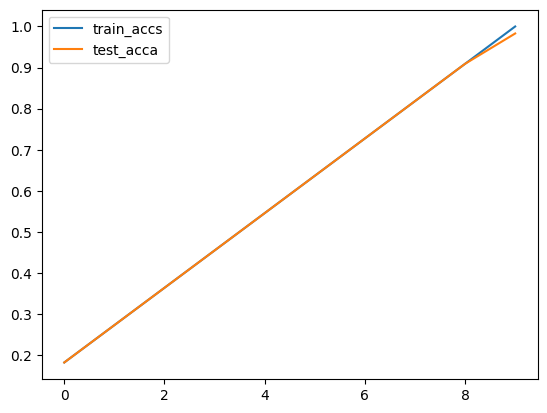

In [58]:
plt.plot(train_accs, label="train_accs")
plt.plot(test_accs, label="test_acca")
plt.legend()
plt.show();

**For the given hyperparameters we see a linearly increasing graph, it can also be seen that the test_accuracy starts lagging neard the tip end.**